## Abnormality Detection in bone X-Rays with DenseNet169

* Katerina Kazantza (p3351801)

In [115]:
import numpy as np
import pandas as pd
import PIL
from tensorflow.keras import layers
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc

### Load Data

In [2]:
dataset_root = Path('data/MURA-v1.1')

In [3]:
list(dataset_root.iterdir())

[WindowsPath('data/MURA-v1.1/train'),
 WindowsPath('data/MURA-v1.1/train_image_paths.csv'),
 WindowsPath('data/MURA-v1.1/train_labeled_studies.csv'),
 WindowsPath('data/MURA-v1.1/valid'),
 WindowsPath('data/MURA-v1.1/valid_image_paths.csv'),
 WindowsPath('data/MURA-v1.1/valid_labeled_studies.csv')]

In [4]:
train_imgpaths_df = pd.read_csv(dataset_root/'train_image_paths.csv', header=None, names=['filename'])
train_imgpaths_df.head()

,filename
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [5]:
train_imgpaths_df['class'] = (train_imgpaths_df.filename
               .str.extract('study.*_(positive|negative)'))
train_imgpaths_df.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


### Data Augmentation
We use Keras’s ImageDataGenerator to perform image augmentation and scale the size of images as 224×224. Then we generate the train and validation dataframes in order to feed the flow_from_dataframe method which have the mapping between filenames of the images and their labels.

In [6]:
def generate_df(dataset_root, csv_name):
    df = pd.read_csv(dataset_root/csv_name, header=None, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    return df

Vertical flip needs to be set as ‘False’. This is because CXR images have a natural orientation — up to down

In [30]:
datagenerator = ImageDataGenerator(rescale = 1. / 255, validation_split=0.3,rotation_range=90,zoom_range=[0.5,1.0])
train_generator = datagenerator.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        subset="training",
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True,
                                        target_size=(224, 224),
                                        class_mode='binary')
valid_generator = datagenerator.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        subset="validation",
                                        batch_size=32,
                                        seed=42,
                                        shuffle=True,
                                        target_size=(224, 224),
                                        class_mode='binary')

test_datagenerator = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagenerator.flow_from_dataframe(generate_df(dataset_root, 'valid_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        batch_size=32,
                                        seed=42,
                                        shuffle=False,
                                        target_size=(224, 224),
                                        class_mode='binary')

Found 25766 validated image filenames belonging to 2 classes.
Found 11042 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


### Densenet 169

#### Create Model

In [8]:
def build_model():
    base_model = tf.keras.applications.DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
    #base_model.trainable = False
    x = base_model.output
    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [9]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc', 'mse'])

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print("STEP_SIZE_TRAIN=",STEP_SIZE_TRAIN,",STEP_SIZE_VALID=",STEP_SIZE_VALID,",STEP_SIZE_TEST=",STEP_SIZE_TEST)

STEP_SIZE_TRAIN= 805 ,STEP_SIZE_VALID= 345 ,STEP_SIZE_TEST= 99


In [11]:
#callbacks for early stopping incase of reduced learning rate, loss unimprovement
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1e-4,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]

#### Train Model

In [12]:
epochs=15
with tf.device('/device:GPU:0'):
    model_history = model.fit(train_generator,
                        epochs=epochs,
                        workers=0,
                        use_multiprocessing=False,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        callbacks=callbacks_list
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 805 steps, validate for 345 steps
Epoch 1/15
805/805 [==============================] - 231s 287ms/step - loss: 0.6060 - acc: 0.6890 - mse: 0.2062 - val_loss: 1.0696 - val_acc: 0.4518 - val_mse: 0.3874
Epoch 2/15
805/805 [==============================] - 211s 262ms/step - loss: 0.5428 - acc: 0.7414 - mse: 0.1801 - val_loss: 0.9471 - val_acc: 0.4685 - val_mse: 0.3447
Epoch 3/15
805/805 [==============================] - 211s 263ms/step - loss: 0.5176 - acc: 0.7638 - mse: 0.1696 - val_loss: 0.8945 - val_acc: 0.4811 - val_mse: 0.3212
Epoch 4/15
804/805 [============================>.] - ETA: 0s - loss: 0.4924 - acc: 0.7779 - mse: 0.1598
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
805/805 [==============================] - 211s 262ms/step - loss: 0.4924 - acc: 0.7779 - mse: 0.1598 - val_loss: 0.9688 - val_acc: 0.5022 - val_mse: 0.3066
Epoch 5/15
805/805 [==============================] - 211s 

#### Saving Model

In [19]:
model.save("models\\densenet\\")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models\densenet\assets


### Evaluation

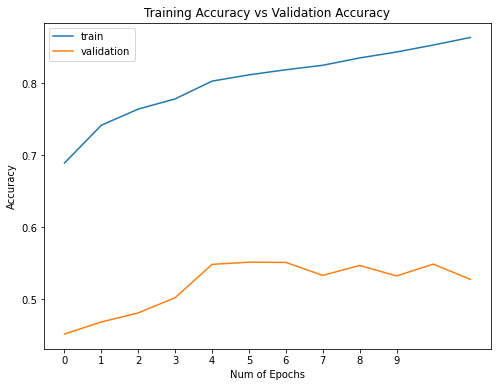

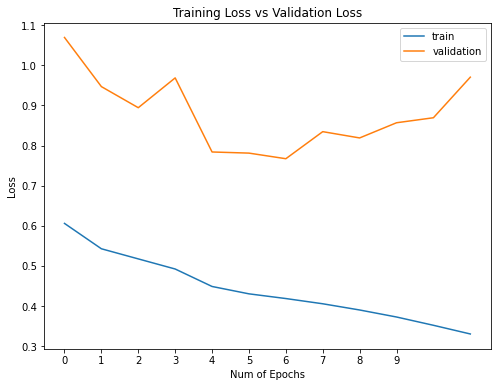

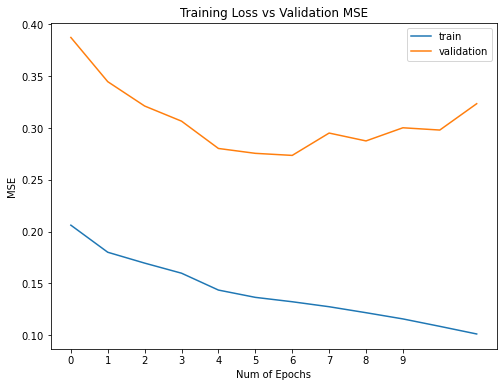

In [27]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(model_history.history['mse'])
plt.plot(model_history.history['val_mse'])
plt.xticks(np.arange(0, 10, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training Loss vs Validation MSE")
plt.legend(['train','validation'])
 
plt.show()

#### Evaluation on test set

In [31]:
ev = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST,  workers=0, use_multiprocessing=False)
ev[1]

  ...
    to  
  ['...']


0.6887626

In [74]:
test_generator.reset()
predictionsDF = pd.DataFrame(model.predict(test_generator),columns=["predictedProb"])

In [92]:
def extract_patient(string):
    patient = string.split('/')[3]+"/"+string.split('/')[4]
    return patient

def class_binarizer(string):
    if string=="positive":
        return 1
    return 0

def probability_binarizer(prob):
    if prob>=0.5:
        return 1
    return 0

def compareActualVsPred(x):
    if x['predClass']==x['actualClass']:
        return 1
    return 0

def create_test_df_for_predict(valid_imgpaths_df):
    valid_imgpaths_df['patient_study'] = valid_imgpaths_df['filename'].apply(extract_patient)
    valid_imgpaths_df['actualClass'] = valid_imgpaths_df['class'].apply(class_binarizer)
    valid_imgpaths_df['predClass'] = valid_imgpaths_df['predictedProb'].apply(probability_binarizer)
    valid_imgpaths_df['predVsActual']= valid_imgpaths_df.apply(compareActualVsPred, axis=1)
    return valid_imgpaths_df

testDF = generate_df(dataset_root, 'valid_image_paths.csv')
testDF = pd.concat([testDF, predictionsDF], axis=1)
test_df = create_test_df_for_predict(testDF)
test_df

,filename,class,predictedProb,patient_study,actualClass,predClass,predVsActual
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.590228,patient11185/study1_positive,1,1,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.583635,patient11185/study1_positive,1,1,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.633055,patient11185/study1_positive,1,1,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,0.696651,patient11185/study1_positive,1,1,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,0.353908,patient11186/study1_positive,1,0,0
...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,0.029656,patient11967/study1_negative,0,0,1
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,0.058165,patient11967/study1_negative,0,0,1
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,0.071658,patient11738/study1_negative,0,0,1
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,0.159198,patient11738/study1_negative,0,0,1


#### Averaging our prediction for each study

In [109]:
df1 = test_df.groupby(['patient_study','actualClass']).agg(
    suma=('predVsActual', 'sum'), counta=('actualClass', 'count'),)
df1 = df1.reset_index()
df1['percentage'] = df1['suma'] / df1['counta']

In [110]:
def majorityBinarizer(x):
    if(x['percentage']>=0.5):
        return x['actualClass']
    else:
        if x['actualClass']==1:
            return 0
    return 1
df1['majorityClass'] = df1.apply(majorityBinarizer, axis=1)

In [111]:
print('Classification Report')
print(classification_report(df1['actualClass'], df1['majorityClass'], target_names=["Negative","Positive"]))

Classification Report
              precision    recall  f1-score   support

    Negative       0.70      0.93      0.80       539
    Positive       0.87      0.54      0.67       469

    accuracy                           0.75      1008
   macro avg       0.79      0.74      0.74      1008
weighted avg       0.78      0.75      0.74      1008



#### Roc & AUC

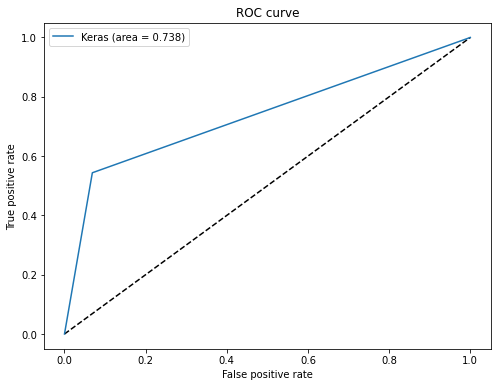

In [117]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(df1['actualClass'], df1['majorityClass'])
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()